# Variation Analysis

In the [_Novel Peptides_](Novel Peptides.ipynb) chapter, novel peptides were identified by Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references) using a proteogenomic search strategy. In addition, this search allowed identifying peptides presenting single amino acid variants (SAAV). 


## Libraries

We will need the following libraries, please make sure that they are installed.

In [2]:
library(conflicted)
library(tidyr)
library(dplyr)
library(ggplot2)
library(scico)
library(gamlss)

theme_set(theme_bw(base_size = 11))

conflict_prefer("filter", "dplyr")
conflict_prefer("select", "dplyr")

Loading required package: splines

Loading required package: gamlss.data


Attaching package: 'gamlss.data'


The following object is masked from 'package:datasets':

    sleep


Loading required package: gamlss.dist

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


Loading required package: parallel

 **********   GAMLSS Version 5.1-4  ********** 

For more on GAMLSS look at http://www.gamlss.org/

Type gamlssNews() to see new features/changes/bug fixes.


[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Will prefer dplyr::select over any other package



## Genotype - peptide abundance relationship

Figure 7h displays the intensity of peptides produced by the reference and alternative alleles of corresponding SNPs for each genotype.

![Figure_7h](resources/images/Fig7h.png?raw=true "Johansson et al. Fig 7h")

> Figure 7h in Johansson _et al._ [(2)](https://gtpb.github.io/IBIP19/pages/proteogenomics/references).

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#if-we-assume-a-linear-relationship-between-number-of-alleles-and-peptide-abundance-what-should-be-the-peptide-distribution-for-each-genotype) _If we assume a linear relationship between number of alleles and peptide abundance, what should be the peptide distribution for each genotype?_

Note that the genotyping data corresponding to the peptide intensities were not made available, but more examples can be found in [Supplementary Figure 15](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape/supplementary_information.pdf).

##### 💬 Do the results presented follow a linear trend? What can affect the linearity of the relationship between number of alleles and intensity distribution? 


## Abundance of variant peptides relative to the proteins

In [Supplementary Table 1](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape) and [Supplementary Table 6](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape), the authors provide the results of their proteogenomic analysis for genes and for peptides carrying alternative alleles of SAAVs, respectively. In addition, [Supplementary Table 1](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape) contains experimental design and sample characterization information. The tables were extracted to an R-friendly text format for this tutorial, and are available in [resources/data/tumor.gz](resources/data/tumor.gz), [resources/data/proteins.gz](resources/data/proteins.gz), and [resources/data/saav.gz](resources/data/saav.gz).

##### 👨‍💻 Load the data in R as in the code below.

In [3]:
tumorDF <- read.table(
    file = "resources/data/tumor.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
)

genesDF <- read.table(
    file = "resources/data/genes.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    select(
        -contains("nspsm")
    )

saavDF <- read.table(
    file = "resources/data/saav.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
)


# Set colors for each tumor type

tumorSubtypes <- unique(tumorDF$PAM50_subtype)
tumorColors <- scico(
    n = length(tumorSubtypes),
    palette = "hawaii"
)
names(tumorColors) <- tumorSubtypes
tumorDF$color <- tumorColors[tumorDF$PAM50_subtype]


Note that for the sake of speed, the last columns of the genes table were skipped.

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#how-do-we-need-to-transform-the-tables-to-compare-saav-peptide-level-intensities-to-gene-level-intensities) _How do we need to transform the tables to compare SAAV peptide-level intensities to gene-level intensities?_

For the sake of time, this data transformation was run for you already. The proposed solution is available in [scripts/merge_table_1_6.R](resources/data/saav.gz), and the reformated SAAV peptides table is available in [resources/data/table16.gz](resources/data/table16.gz). Note that in this table one row represents a unique _{peptide sequence, gene accession}_ pair.

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#why-can-there-be-multiple-peptide-per-gene-and-gene-per-peptide-is-it-correct-to-represent-peptides-by-their-sequence) _Why can there be multiple peptide per gene, and gene per peptide? Is it correct to represent peptides by their sequence?_

In the following, we want to compare the abundances associated to SAAV peptides to the abundances aggregated at the gene-level. For each tumor, we will therefore only retain quantified _{peptide, gene}_ pairs.

##### 👨‍💻 Load the reformated SAAV peptides table.

In [4]:
# Load the table

saavDF <- read.table(
    file = "resources/data/table16.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
)


# Place holder for column names

tumorPeptideColumns <- paste0(tumorDF$tumor_id, "_saavPeptide")
tumorGeneColumns <- paste0(tumorDF$tumor_id, "_gene")
tumorColumns <- c(tumorPeptideColumns, tumorGeneColumns)


# For each tumor, keep only pairs of gene and peptide pairs

for (tumor in tumorDF$tumor_id) {
    
    peptideColumn <- paste0(tumor, "_saavPeptide")
    geneColumn <- paste0(tumor, "_gene")
    
    saavDF[[peptideColumn]][is.na(saavDF[[geneColumn]])] <- NA
    saavDF[[geneColumn]][is.na(saavDF[[peptideColumn]])] <- NA
    
}


# Remove lines with no quantification value

nValid <- rowSums(!is.na(saavDF[, tumorColumns]))
saavDF <- saavDF[nValid > 0,]

##### 👨‍💻 Plot the intensity distributions as violin and box plots for the different tumors

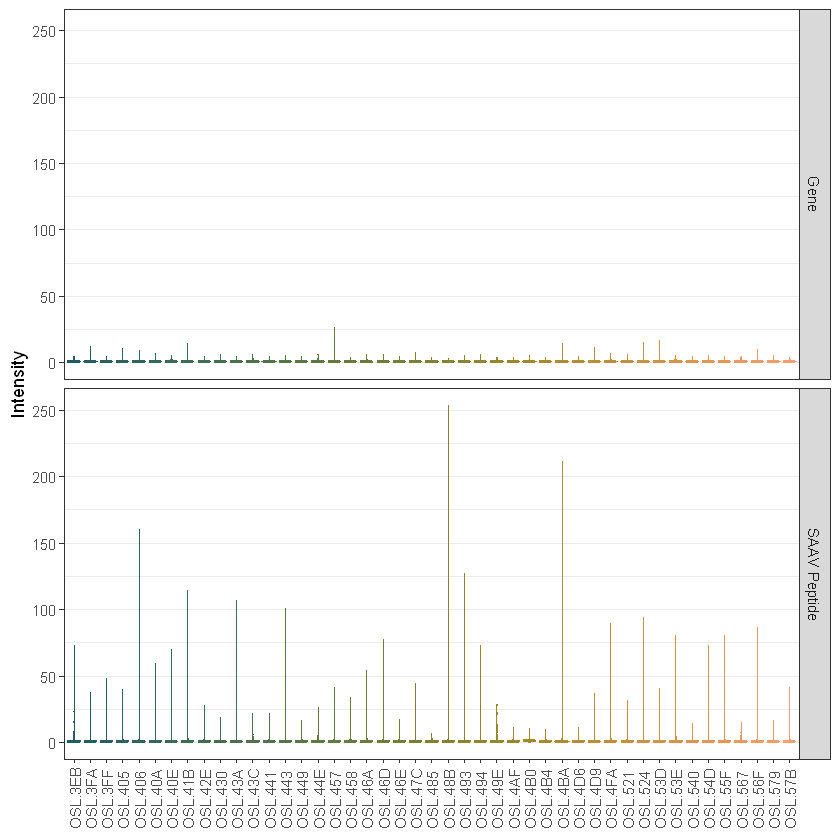

In [6]:
# Transform the saav data frame from wide to long format using tidyr

intensitiesDF <- saavDF %>%
    gather(
        !!tumorColumns,
        key = "sample",
        value = "intensity"
    ) %>%
    filter(
        !is.na(intensity) & !is.infinite(intensity)
    ) %>%
    separate(
        col = sample,
        into = c("tumor", "species"),
        sep = "_"
    )


# Set levels for genes and peptides

intensitiesDF$species <- factor(
    intensitiesDF$species, 
    levels = c("gene", "saavPeptide")
)
levels(intensitiesDF$species) <- c("Gene", "SAAV Peptide")


# Build the plot

ggplot(
    data = intensitiesDF
) +
    geom_violin(
        mapping = aes(
            x = tumor,
            y = intensity,
            col = tumor
        ),
        fill = NA
    ) +
    geom_boxplot(
        mapping = aes(
            x = tumor,
            y = intensity,
            col = tumor
        ),
        fill = NA,
        outlier.shape = NA
    ) +
    facet_grid(
        species ~ .
    ) + 
    scale_fill_manual(
        values = scico(
            n = length(unique(intensitiesDF$tumor)),
            palette = "batlow",
            begin = 0.25,
            end = 0.75
        )
    ) +
    scale_color_manual(
        values = scico(
            n = length(unique(intensitiesDF$tumor)),
            palette = "batlow",
            begin = 0.25,
            end = 0.75
        )
    ) + 
    scale_y_continuous(
        name = "Intensity"
    ) + 
    theme(
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.text.x = element_text(
            angle = 90,
            hjust = 0,
            vjust = 0.5
            
        ),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
    )

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#why-are-all-intensities-at-the-bottom-how-can-we-transform-the-data-to-better-visualize-these-distributions) _Why are all intensities at the bottom? How can we transform the data to better visualize these distributions?_

As you can see, the gene-level intensities are centered around one, and not for the peptide-level. You might have noticed in the paper that the gene-level data as provided in the supplementary information are centered, but this was not done for the peptides.

##### 💬 In your opinion why were the protein data centered? How would you recommend normalizing these data? Why?

Here, we hypothesize that SAAV peptides are sampled from these genes and should therefore present the same abundance distribution. Data acquisition and processing artefacts can influence the centering and scaling. To correct for this, we will normalize the abundances from all tumors using centile-based Z-scores.

In [7]:
# Placeholder for the z-transformed columns

zTumorColumns <- paste0("z_", tumorColumns)
zTumorPeptideColumns <- paste0("z_", tumorPeptideColumns)
zTumorGeneColumns <- paste0("z_", tumorGeneColumns)


# Iterate through the tumor columns

for (column in tumorColumns) {
    
    
    # Create a column name for the z-score transformed variables
    
    zColumn <- paste0("z_", column)
    
    
    # Create a data frame with only the columns of interest and filter out NA, zero, and infinite values
    
    trainingDF <- saavDF %>%
        select(
            gene, peptide_sequence, !!column
        ) %>%
        filter(
            !is.na(!!sym(column)) & !is.infinite(!!sym(column)) & !!sym(column) > 0
        )
    
    
    # Train the model
    
    trainingDF$x <- 0 # Note that it is possible to include covariates in the model instead of using a constant here
    
    model <- gamlss(
        formula = as.formula(paste0(column, " ~ x")),
        family = LOGNO,
        data = trainingDF,
        
    )
    
    
    # Compute the z-scores
    
    trainingDF[[zColumn]] <- centiles.pred(
        obj = model, 
        xname = "x", 
        xvalues = trainingDF$x, 
        yval = trainingDF[[column]], 
        type = "z-scores"
    )
    
    
    # Extract the transformed values
    
    trainingDF <- trainingDF %>%
        filter(
            !is.infinite(!!sym(zColumn))
        ) %>%
        select(
            gene, peptide_sequence, !!zColumn
        )
    
    
    # Merge with the saav data frame
    
    saavDF <- saavDF %>%
        left_join(
            trainingDF,
            by = c("gene", "peptide_sequence")
        )
    
}


# For each tumor, keep only pairs of gene and peptide pairs

for (tumor in tumorDF$tumor_id) {
    
    peptideColumn <- paste0("z_", tumor, "_saavPeptide")
    geneColumn <- paste0("z_", tumor, "_gene")
    
    saavDF[[peptideColumn]][is.na(saavDF[[geneColumn]])] <- NA
    saavDF[[geneColumn]][is.na(saavDF[[peptideColumn]])] <- NA
    
}


# Remove lines with no normalized quantification value

nValid <- rowSums(!is.na(saavDF[, zTumorColumns]))
saavDF <- saavDF[nValid > 0,]

GAMLSS-RS iteration 1: Global Deviance = 2027.455 
GAMLSS-RS iteration 2: Global Deviance = 2027.455 
GAMLSS-RS iteration 1: Global Deviance = 1300.237 
GAMLSS-RS iteration 2: Global Deviance = 1300.237 
GAMLSS-RS iteration 1: Global Deviance = 1880.204 
GAMLSS-RS iteration 2: Global Deviance = 1880.204 
GAMLSS-RS iteration 1: Global Deviance = 1857.933 
GAMLSS-RS iteration 2: Global Deviance = 1857.933 
GAMLSS-RS iteration 1: Global Deviance = 2045.205 
GAMLSS-RS iteration 2: Global Deviance = 2045.205 
GAMLSS-RS iteration 1: Global Deviance = 1966.413 
GAMLSS-RS iteration 2: Global Deviance = 1966.413 
GAMLSS-RS iteration 1: Global Deviance = 1566.112 
GAMLSS-RS iteration 2: Global Deviance = 1566.112 
GAMLSS-RS iteration 1: Global Deviance = 1491.397 
GAMLSS-RS iteration 2: Global Deviance = 1491.397 
GAMLSS-RS iteration 1: Global Deviance = 1600.611 
GAMLSS-RS iteration 2: Global Deviance = 1600.611 
GAMLSS-RS iteration 1: Global Deviance = 1454.124 
GAMLSS-RS iteration 2: Global D

##### 👨‍💻  For a tumor and plot the normalized values against the original ones.

Warning message:
"Removed 1426 rows containing missing values (geom_point)."


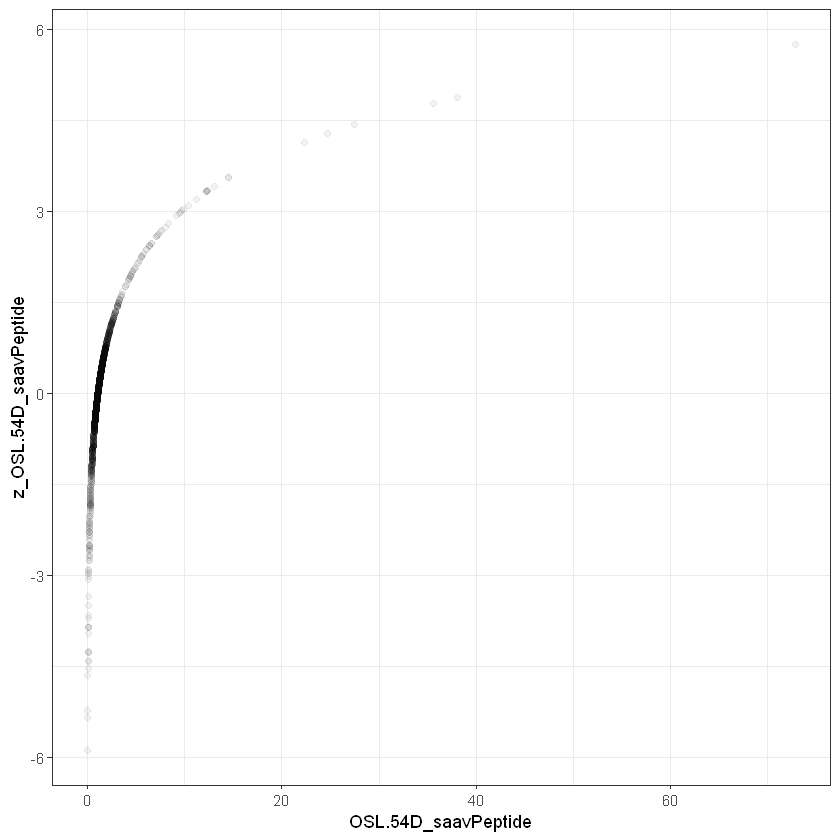

In [8]:
# Select a column randomly

column <- sample(
    x = tumorColumns,
    size = 1
)
zColumn <- paste0("z_", column)


# Build the plot

ggplot(
    data = saavDF
) +
    geom_point(
        mapping = aes(
            x = !!sym(column),
            y = !!sym(zColumn)
        ),
        alpha = 0.05
    )

##### [❔](https://github.com/GTPB/IBIP19/blob/master/pages/proteogenomics/answers.md#why-does-the-curve-have-this-shape) _Why does the curve have this shape?_

##### 👨‍💻 Plot the distributions like before after normalization.

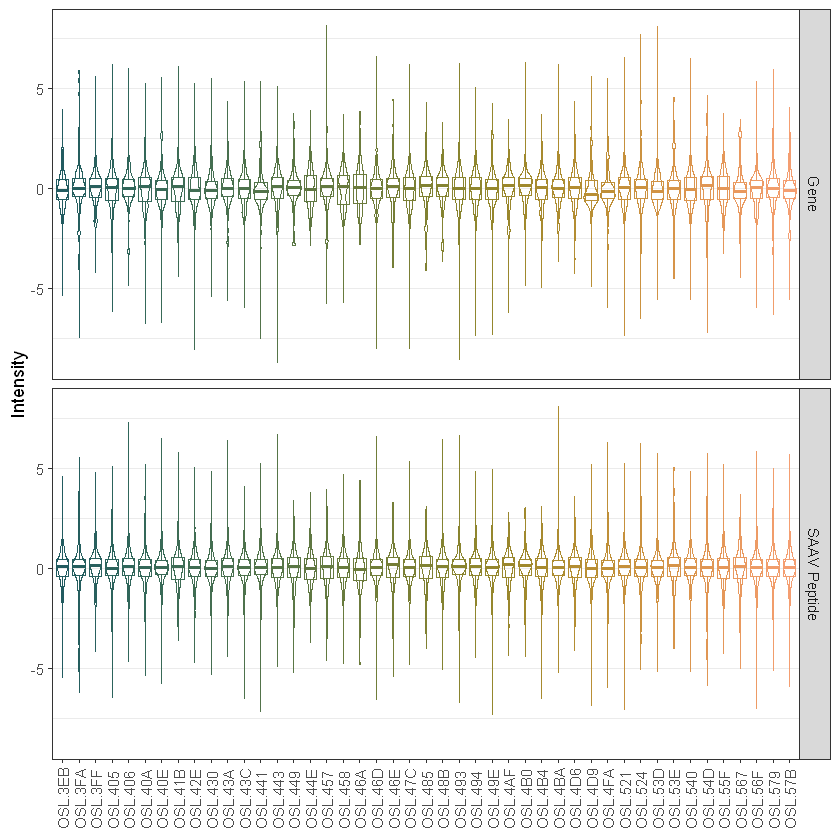

In [9]:
# Transform the saav data frame from wide to long format using tidyr

intensitiesDF <- saavDF %>%
    select(
        -!!tumorColumns
    ) %>%
    gather(
        !!zTumorColumns,
        key = "sample",
        value = "intensity"
    ) %>%
    filter(
        !is.na(intensity) & !is.infinite(intensity)
    ) %>%
    separate(
        col = sample,
        into = c(NA, "tumor", "species"),
        sep = "_"
    )


# Set levels for the genes and peptides

intensitiesDF$species <- factor(
    intensitiesDF$species, 
    levels = c("gene", "saavPeptide")
)
levels(intensitiesDF$species) <- c("Gene", "SAAV Peptide")


# Build the plot

ggplot(
    data = intensitiesDF
) +
    geom_violin(
        mapping = aes(
            x = tumor,
            y = intensity,
            col = tumor
        ),
        fill = NA
    ) +
    geom_boxplot(
        mapping = aes(
            x = tumor,
            y = intensity,
            col = tumor
        ),
        fill = NA,
        outlier.shape = NA
    ) +
    facet_grid(
        species ~ .
    ) + 
    scale_fill_manual(
        values = scico(
            n = length(unique(intensitiesDF$tumor)),
            palette = "batlow",
            begin = 0.25,
            end = 0.75
        )
    ) +
    scale_color_manual(
        values = scico(
            n = length(unique(intensitiesDF$tumor)),
            palette = "batlow",
            begin = 0.25,
            end = 0.75
        )
    ) + 
    scale_y_continuous(
        name = "Intensity"
    ) + 
    theme(
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.text.x = element_text(
            angle = 90,
            hjust = 0,
            vjust = 0.5
            
        ),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
    )


##### 👨‍💻 Plot the gene- and peptide- level abundances.


Call:
lm(formula = saav_peptide_abundance ~ gene_abundance, data = intensitiesDF)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9059 -0.3102  0.0856  0.4188  7.9737 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.0002376  0.0038858  -0.061    0.951    
gene_abundance  0.3064531  0.0038919  78.741   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9514 on 59945 degrees of freedom
Multiple R-squared:  0.09373,	Adjusted R-squared:  0.09372 
F-statistic:  6200 on 1 and 59945 DF,  p-value: < 2.2e-16


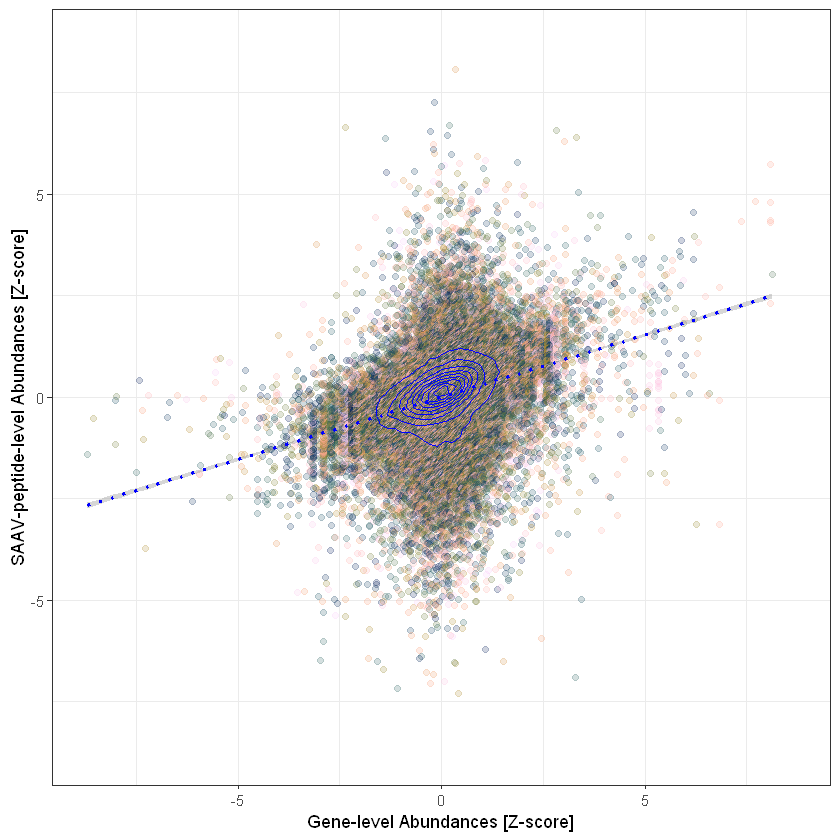

In [10]:
# Transform the saav data frame from wide to long format, and separate genes and proteins using tidyr

intensitiesDF <- saavDF %>%
    select(
        -!!tumorColumns
    ) %>%
    gather(
        !!zTumorColumns,
        key = "sample",
        value = "intensity"
    ) %>%
    filter(
        !is.na(intensity) & !is.infinite(intensity)
    ) %>%
    separate(
        col = sample,
        into = c(NA, "tumor", "species"),
        sep = "_"
    ) %>%
    mutate (
        species = ifelse(species == "gene", "gene_abundance", "saav_peptide_abundance")
    ) %>%
    spread(
        key = species,
        value = intensity
    ) %>%
    filter(
        !is.na(saav_peptide_abundance) & !is.na(gene_abundance)
    ) %>%
    arrange(
        abs(saav_peptide_abundance - gene_abundance)
    )


# Run a linear model, for each tumor separately then for all values

model <- lm(
    data = intensitiesDF,
    formula = saav_peptide_abundance ~ gene_abundance
)

summary(model)


# Build the plot

axisLimit <- max(abs(c(intensitiesDF$gene_abundance, intensitiesDF$saav_peptide_abundance)))

ggplot(
    data = intensitiesDF
) +
    geom_point(
        mapping = aes(
            x = gene_abundance,
            y = saav_peptide_abundance,
            col = tumor
        ),
        alpha = 0.2
    ) +
    geom_density2d(
        mapping = aes(
            x = gene_abundance,
            y = saav_peptide_abundance,
        ),
        col = "blue"
    ) + 
    geom_smooth(
        mapping = aes(
            x = gene_abundance,
            y = saav_peptide_abundance,
        ),
        method = 'lm',
        formula = y ~ x,
        col = "blue",
        linetype = "dotted"
    ) +
    scale_x_continuous(
        name = "Gene-level Abundances [Z-score]",
        limits = c(-axisLimit, axisLimit)
    ) +
    scale_y_continuous(
        name = "SAAV-peptide-level Abundances [Z-score]",
        limits = c(-axisLimit, axisLimit)
    ) +
    scale_color_manual(
        name = "Tumor Subtype",
        values = scico(
            n = length(unique(intensitiesDF$tumor)),
            palette = "batlow"
        )
    ) +
    theme(
        legend.position = "none"
    )

##### 💬 What do you think about the SAAV peptide to gene agreement?

In the following, we will inspect the correlation of the profile across tumors for the abundances reported for genes and SAAV peptides. Note that we will use random values to compare our results with what one would expect by chance.

##### 👨‍💻 Plot a histogram of pairwise correlation between protein and peptide abundances across tumors, compare with random values.

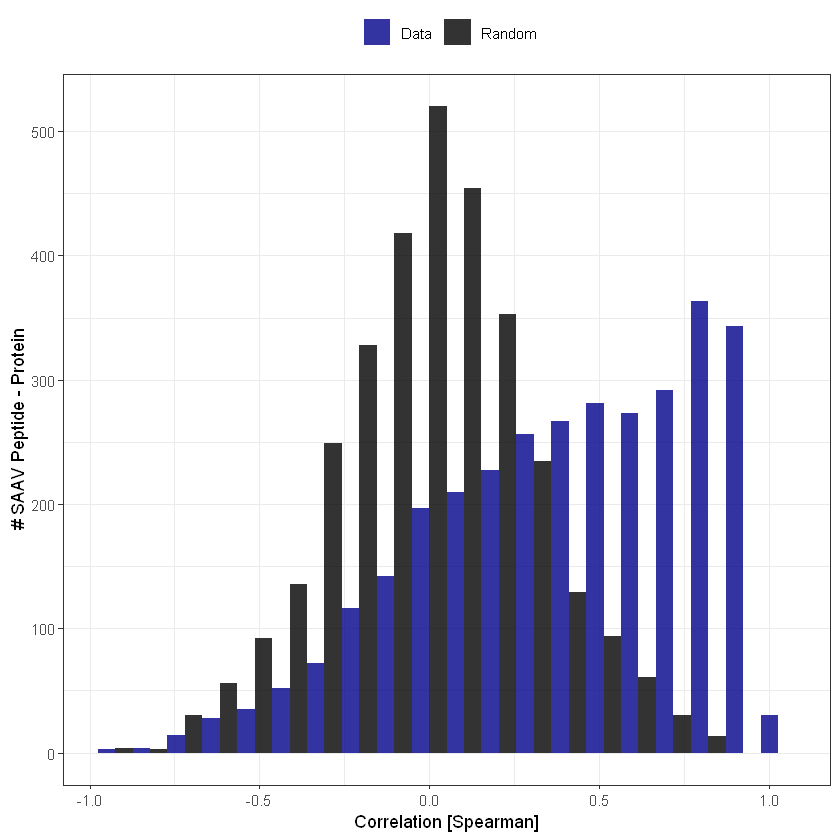

In [11]:

# Select rows where there are at least 8 peptide-protein pairs

saavDF$nPeptideValid <- rowSums(!is.na(saavDF[, zTumorPeptideColumns]))
saavDF$nGeneValid <- rowSums(!is.na(saavDF[, zTumorGeneColumns]))
corDF <- saavDF[saavDF$nPeptideValid >= 8 & saavDF$nGeneValid >= 8,]


# Compute correlation by row

corDF$cor <- NA
corDF$rCor <- NA

for (i in 1:nrow(corDF)) {
    
    x <- t(corDF[i, zTumorGeneColumns])
    y <- t(corDF[i, zTumorPeptideColumns])
    
    corDF$cor[i] <- cor(
        x = x,
        y = y,
        use = "pairwise.complete.obs",
        method = "spearman"
    )
    
    n <- sum(!is.na(x) & !is.na(y))
    x <- rnorm(n)
    y <- rnorm(n)
    
    corDF$rCor[i] <- cor(
        x = x,
        y = y,
        use = "pairwise.complete.obs",
        method = "spearman"
    )
    
}


# Transform the example data frame from wide to long format

plotDF <- corDF %>%
    select(
        gene, peptide_sequence, cor, rCor
    ) %>%
    gather(
        cor, rCor,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "cor", "Data", "Random")
    )


# Build plot

ggplot(
    data = plotDF
) +
    geom_histogram(
        mapping = aes(
            x = correlation,
            fill = data
        ),
        alpha = 0.8,
        bins = 20,
        position = "dodge"
    ) +
    scale_x_continuous(
        name = "Correlation [Spearman]"
    ) +
    scale_y_continuous(
        name = "# SAAV Peptide - Protein"
    ) +
    scale_fill_manual(
        values = c("darkblue", "black")
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


##### 💬 How do you interpret this distribution? What peptides are likely to provide information on the tumors that is othogonal to the proteome?

##### 👨‍💻  Sample examples of peptide-protein pairs at the bottom, middle, and top of the distribution, and plot their profiles among tumors.

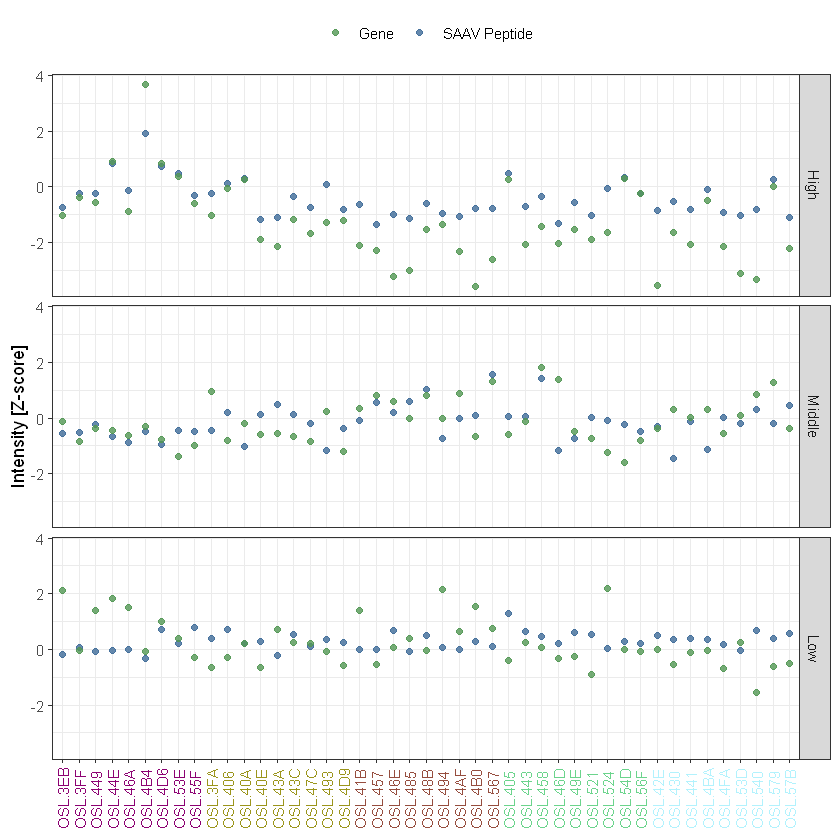

In [13]:
# Sample

exampleLow <- corDF %>%
    filter(
        cor < -0.5
    ) %>%
    arrange(
        desc(nPeptideValid)
    ) %>%
    slice(
        1
    ) %>%
    mutate(
        correlation_category = "Low"
    )
exampleMiddle <- corDF %>%
    filter(
        cor > -0.2 & cor < 0.2
    ) %>%
    arrange(
        desc(nPeptideValid)
    ) %>%
    slice(
        1
    ) %>%
    mutate(
        correlation_category = "Middle"
    )
exampleHigh <- corDF %>%
    filter(
        cor > 0.8
    ) %>%
    arrange(
        desc(nPeptideValid)
    ) %>%
    slice(
        1
    ) %>%
    mutate(
        correlation_category = "High"
    )

exampleDF <- rbind(
    exampleLow, 
    exampleMiddle,
    exampleHigh
) %>%
    mutate(
        correlation_category = factor(
            x = correlation_category, 
            levels = c("High", "Middle", "Low")
        )
    )


# Transform the example data frame from wide to long format

plotDF <- exampleDF %>%
    select(
        -!!tumorColumns
    ) %>%
    gather(
        !!zTumorColumns,
        key = "sample",
        value = "intensity"
    ) %>%
    filter(
        !is.na(intensity) & !is.infinite(intensity)
    ) %>%
    separate(
        col = sample,
        into = c(NA, "tumor", "species"),
        sep = "_"
    ) %>%
    mutate(
        species = factor(
            x = ifelse(species == "gene", "Gene", "SAAV Peptide"),
            levels = c("Gene", "SAAV Peptide")
        )
    )


# Order the tumors by category

tumorDF <- tumorDF %>%
    arrange(
        PAM50_subtype, tumor_id
    )

plotDF$tumor <- factor(
    x = plotDF$tumor, 
    levels = tumorDF$tumor_id
)


# Build plot

ggplot(
    data = plotDF
) +
    geom_point(
        mapping = aes(
            x = tumor,
            y = intensity,
            col = species
        ),
        alpha = 0.8
    ) + 
    facet_grid(
        correlation_category ~ .
    ) +
    scale_y_continuous(
        name = "Intensity [Z-score]"
    ) +
    scale_color_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank(),
        axis.title.x = element_blank(),
        axis.text.x = element_text(
            angle = 90,
            hjust = 0,
            vjust = 0.5,
            color = tumorDF$color
        )
    )

##### 💬 How do you interpret differences in correlation between abundances reported for genes or SAAV peptides? 

In the following, we investigate whether specific classes of variants influence the correlation between SAAV peptide- and gene-level abundances. For this, we query the [Ensembl Variant Effect Predictor (VEP)](ensembl.org/Homo_sapiens/Tools/VEP) using the variant identifiers reported in [Supplementary Table 6](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape). For the sake of time, we will not query VEP as part of this tutorial, this was already done for you, and the VEP results are available in [resources/data/vep.txt](resources/data/vep.txt). Note that only variants with an _rsID_ were used in this analysis.

##### 👨‍💻 Import the VEP results and merge with the correlation data frame.

In [14]:
# Load the file, select the columns of interest, format the columns and content

vepDF <- read.table(
    file = "resources/data/vep.txt",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    filter(
        Consequence %in% c("missense_variant", "coding_sequence_variant") & BIOTYPE == "protein_coding"
    ) %>%
    select(
        SYMBOL, Uploaded_variation, MutationAssessor_pred, clinvar_clnsig, clinvar_trait, gnomAD_exomes_NFE_AF, LoFtool
    ) %>%
    rename(
        gene_variant = Uploaded_variation,
        gene = SYMBOL,
        functionality_prediction = MutationAssessor_pred,
        clinical_significance = clinvar_clnsig,
        allele_frequency = gnomAD_exomes_NFE_AF,
        loss_of_function = LoFtool
    ) %>%
    mutate(
        allele_frequency = as.numeric(allele_frequency),
        allele_frequency = ifelse(allele_frequency > 0.5, 1 - allele_frequency, allele_frequency),
        allele_frequency = log10(allele_frequency),
        functionality_prediction = ifelse(functionality_prediction == "N", "Neutral", 
                                          ifelse(functionality_prediction == "L", "Low", 
                                                 ifelse(functionality_prediction == "M", "Medium", 
                                                        ifelse(functionality_prediction == "H", "High", NA
                                                        )))),
        functionality_prediction = factor(
            x = functionality_prediction,
            levels = c("Neutral", "Low", "Medium", "High")
        ),
        clinical_significance = ifelse(grepl(x = clinical_significance, pattern = "5"), "Pathogenic", 
                                       ifelse(grepl(x = clinical_significance, pattern = "4"), "Likely pathogenic", 
                                              ifelse(grepl(x = clinical_significance, pattern = "3"), "Likely benign", 
                                                     ifelse(grepl(x = clinical_significance, pattern = "2"), "Benign", NA
                                                     )))),
        clinical_significance = factor(
            x = clinical_significance,
            levels = c("Benign", "Likely benign", "Likely pathogenic", "Pathogenic")
        ),
        loss_of_function = as.numeric(loss_of_function)
    ) %>%
    distinct()


# Merge with the correlation data frame

corVepDF <- corDF %>%
    select(
        peptide_sequence, gene, gene_variant, cor, rCor
    ) %>%
    left_join(
        vepDF,
        by = c("gene", "gene_variant")
    )

Warning message:
"NAs introduced by coercion"
Warning message:
"NAs introduced by coercion"


##### 👨‍💻 Plot the distribution of the correlation against the minor allele frequency

Warning message:
"Removed 276 rows containing non-finite values (stat_smooth)."


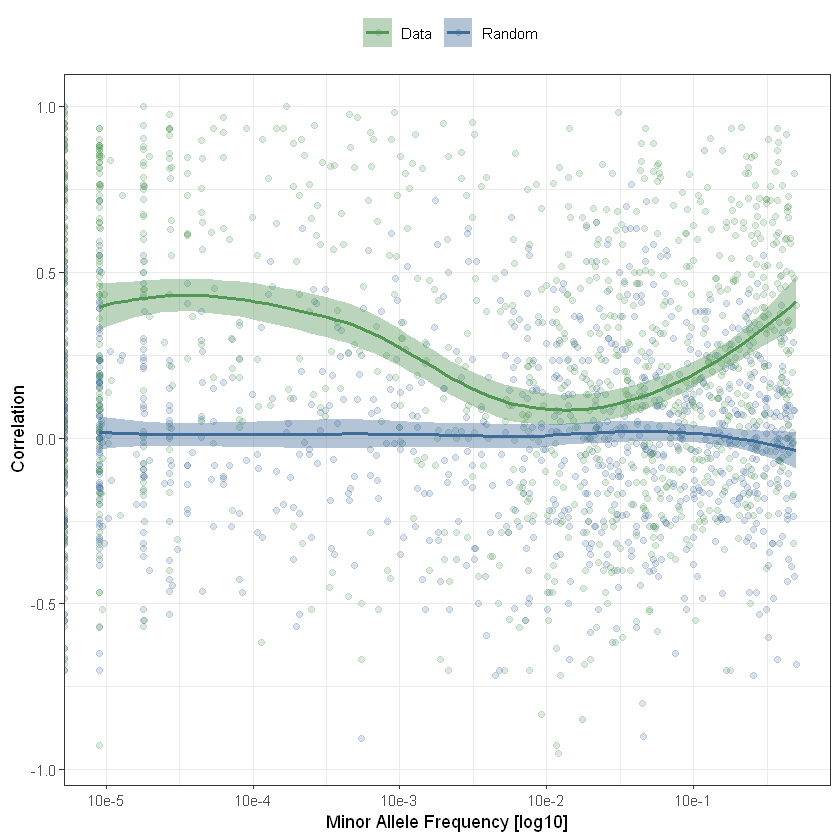

In [15]:
plotDF <- corVepDF %>%
    select(
        peptide_sequence, gene, gene_variant, cor, rCor, allele_frequency
    ) %>%
    filter(
        !is.na(allele_frequency)
    ) %>%
    distinct() %>%
    gather(
        cor, rCor,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "cor", "Data", "Random"),
        data = factor(
            x = data, 
            levels = c("Data", "Random")
        )
    ) %>%
    arrange(
        desc(data)
    )

ggplot(
    data = plotDF
) +
    geom_point(
        mapping = aes(
            x = allele_frequency,
            y = correlation,
            col = data
        ),
        alpha = 0.2
    ) +
    geom_smooth(
        mapping = aes(
            x = allele_frequency,
            y = correlation,
            col = data,
            fill = data
        ),
        method = "loess"
    ) +
    scale_x_continuous(
        name = "Minor Allele Frequency [log10]",
        breaks = -5:-1,
        labels = paste0("10e", -5:-1)
    ) +
    scale_y_continuous(
        name = "Correlation"
    ) +
    scale_color_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    scale_fill_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )

##### 💬 Intuitively, what frequency do you expect variants promoting tumor survival to have?


##### 👨‍💻 Plot the distribution of the correlation against the functionality prediction

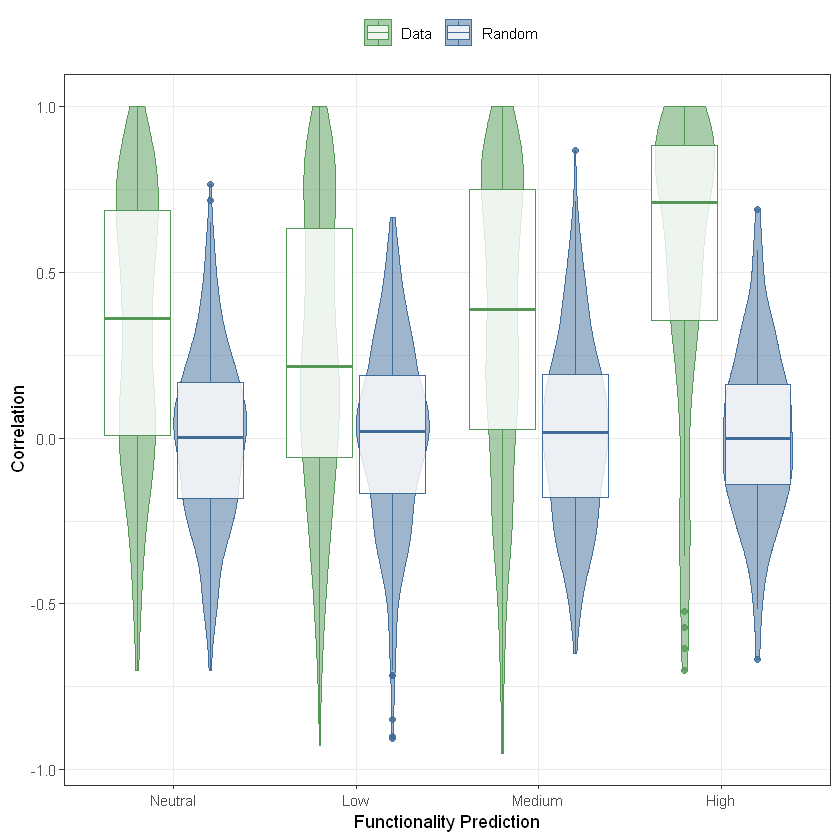

In [16]:

plotDF <- corVepDF %>%
    select(
        peptide_sequence, gene, gene_variant, cor, rCor, functionality_prediction
    ) %>%
    filter(
        !is.na(functionality_prediction)
    ) %>%
    distinct() %>%
    gather(
        cor, rCor,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "cor", "Data", "Random"),
        data = factor(
            x = data, 
            levels = c("Data", "Random")
        )
    ) %>%
    arrange(
        desc(data)
    )

ggplot(
    data = plotDF
) +
    geom_violin(
        mapping = aes(
            x = functionality_prediction,
            y = correlation,
            col = data,
            fill = data
        ),
        alpha = 0.5,
        width = 0.8
    ) +
    geom_boxplot(
        mapping = aes(
            x = functionality_prediction,
            y = correlation,
            col = data
        ),
        fill = "white",
        alpha = 0.8,
        width = 0.8
    ) +
    scale_x_discrete(
        name = "Functionality Prediction"
    ) +
    scale_y_continuous(
        name = "Correlation"
    ) +
    scale_color_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    scale_fill_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )

##### 💬 How can we interpret that protein and SAAV correlation is associated with functional prediction?


##### 👨‍💻 Plot the distribution of the correlation against the loss of function prediction

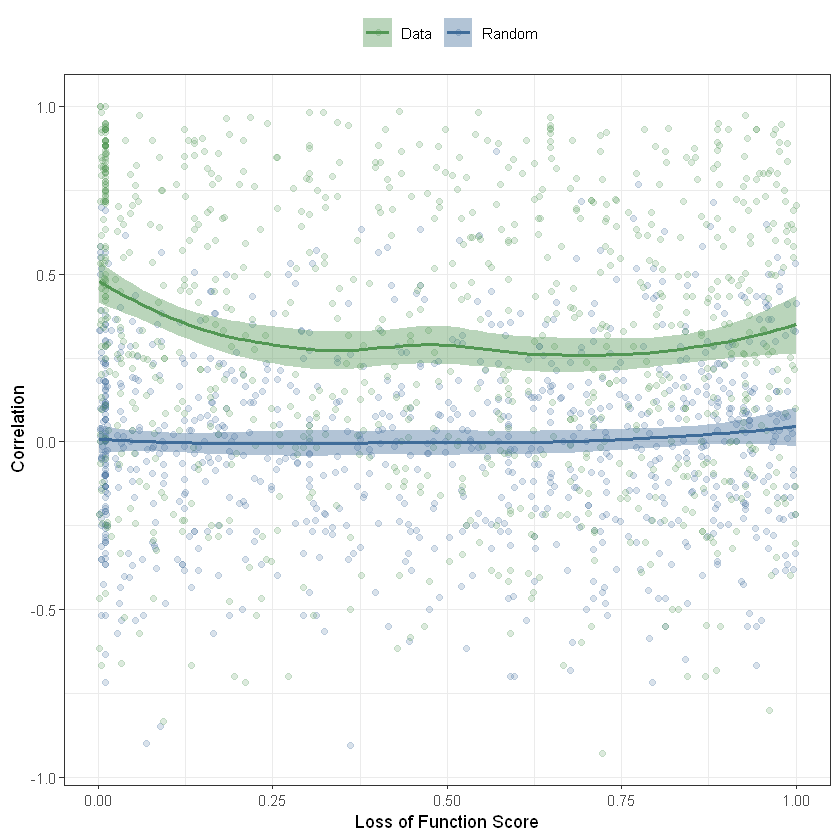

In [17]:
plotDF <- corVepDF %>%
    select(
        peptide_sequence, gene, gene_variant, cor, rCor, loss_of_function
    ) %>%
    filter(
        !is.na(loss_of_function)
    ) %>%
    distinct() %>%
    gather(
        cor, rCor,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "cor", "Data", "Random"),
        data = factor(
            x = data, 
            levels = c("Data", "Random")
        )
    ) %>%
    arrange(
        desc(data)
    )

ggplot(
    data = plotDF
) +
    geom_point(
        mapping = aes(
            x = loss_of_function,
            y = correlation,
            col = data
        ),
        alpha = 0.2
    ) +
    geom_smooth(
        mapping = aes(
            x = loss_of_function,
            y = correlation,
            col = data,
            fill = data
        ),
        method = "loess"
    ) +
    scale_x_continuous(
        name = "Loss of Function Score"
    ) +
    scale_y_continuous(
        name = "Correlation"
    ) +
    scale_color_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    scale_fill_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


##### 💬 Intuitively, how do you expect the correlation to evolve relatively to the loss of function score?


##### 👨‍💻 Plot the distribution of the correlation against the loss of clinical significance

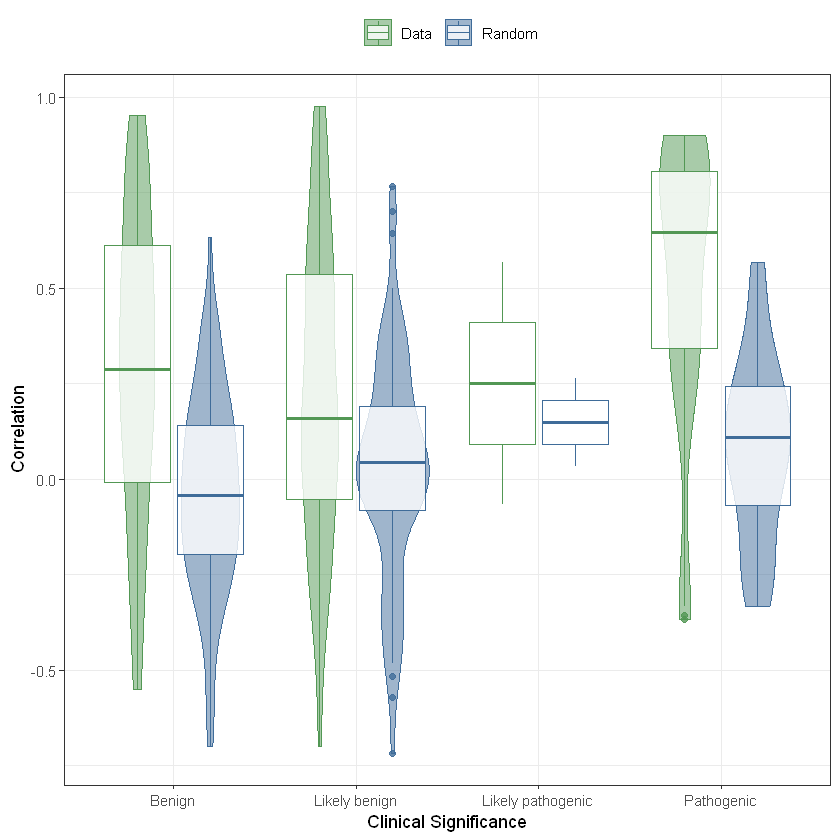

In [19]:
plotDF <- corVepDF %>%
    select(
        peptide_sequence, gene, gene_variant, cor, rCor, clinical_significance
    ) %>%
    filter(
        !is.na(clinical_significance)
    ) %>%
    distinct() %>%
    gather(
        cor, rCor,
        key = "data",
        value = "correlation"
    ) %>%
    mutate(
        data = ifelse(data == "cor", "Data", "Random"),
        data = factor(
            x = data, 
            levels = c("Data", "Random")
        )
    ) %>%
    arrange(
        desc(data)
    )

ggplot(
    data = plotDF
) +
    geom_violin(
        mapping = aes(
            x = clinical_significance,
            y = correlation,
            col = data,
            fill = data
        ),
        alpha = 0.5,
        width = 0.8
    ) +
    geom_boxplot(
        mapping = aes(
            x = clinical_significance,
            y = correlation,
            col = data
        ),
        fill = "white",
        alpha = 0.8,
        width = 0.8
    ) +
    scale_x_discrete(
        name = "Clinical Significance"
    ) +
    scale_y_continuous(
        name = "Correlation"
    ) +
    scale_color_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    scale_fill_manual(
        values = scico(
            n = 2,
            palette = "cork",
            begin = 0.2,
            end = 0.8,
            direction = -1
        )
    ) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )

##### 💬 How do you interpret the association of correlation between gene and SAAV peptides abundances in tumors and pathogenicity? How can we take advantage of the variant association in other diseases?


## Conclusion

##### 👨‍💻 Can you speculate on the function or effect of these variant peptides in cancer biology? How can these be used in a clinical setup?